# Regressão: Previsão de consumo de combustível

Aula Prática - 30/10/2019


Em um problema de regressão, o objetivo é prever as saídas (outputs) de um valor contínuo, como um preço ou probabilidade. Em contraste de problemas de classificação, onde temos o propósito de escolher uma classe em uma lista de classificações (por exemplo, se uma imagem contém uma maçã ou laranja, assim reconhecendo qual fruta é representada na imagem).

Este notebook usa a clássica base de dados Auto MPG e constrói um modelo para prever a economia de combustíveis de automóveis do final dos anos 1970, início dos anos 1980. Para isso, forneceremos um modelo com descrição de vários automóveis desse período. Essa descrição inclui atributos como: cilindros, deslocamento, potência do motor, e peso.

Este exemplo usa a API tf.keras. Veja este guia para mais detalhes.

In [0]:
# Use seaborn para pairplot
!pip install -q seaborn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


#Base de dados Auto MPG
A base de dados está disponível em UCI Machine Learning Repository.

Pegando os dados
Primeiro baixe a base de dados dos automóveis.

In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path



'/root/.keras/datasets/auto-mpg.data'

In [0]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#Limpe os dados



**Esta base contém alguns valores não conhecidos (unknown).**

In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

# Remova as linhas com esses valores não conhecidos.

In [0]:
dataset = dataset.dropna()

# Separando dados de treinamento e teste

Agora separe os dados em um conjunto de treinamento e outro teste.

Iremos utilizar o de conjunto de teste no final da análise do model.

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Repare na visão geral dos estatísticas:



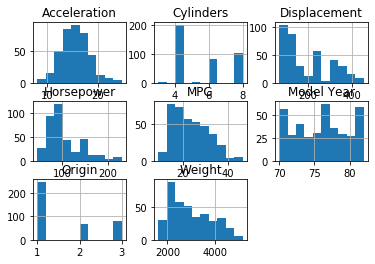

In [0]:
dataset.hist()
plt.show()

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


#Plots

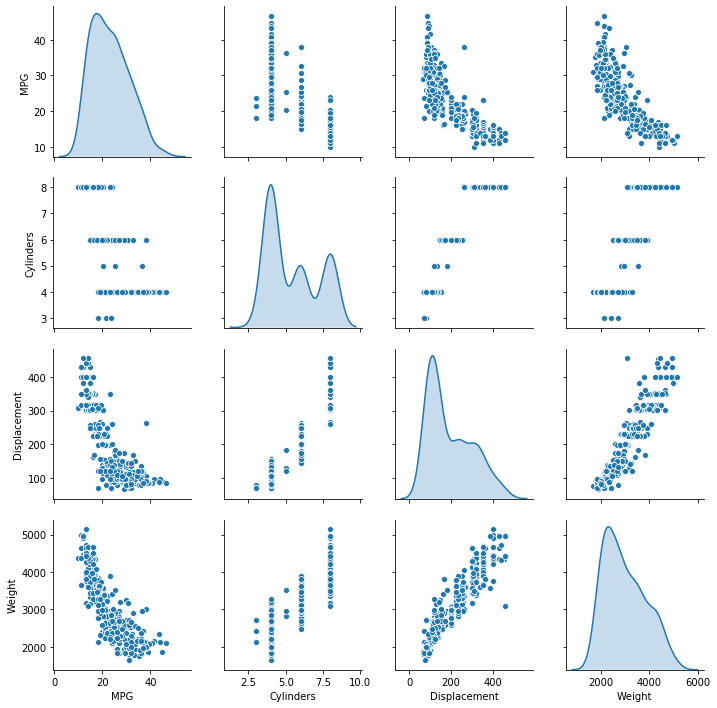

In [0]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


# Separe features de labels

Separe o valor alvo (labels), das features. Essa label é o valor no qual o modelo é treinado para prever.

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# Normalize os dados


Observe novamente o train_stats acima e note quão diferente são os intervalos de uma feature e outra.

Uma boa prática é normalizar as features que usam diferentes escalas e intervalos. Apesar do modelo poder convergir sem a normalização, isso torna o treinamento mais difícil, e torna o resultado do modelo dependente da escolha das unidades da entrada.

Observação: embora geramos intencionalmente essas estatísticas para os dados de treinamento, essas estatísticas serão usadas também para normalizar o conjunto de teste. Precisamos delinear o conjunto de teste na mesma distribuição que o modelo foi treinado.

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#O Modelo

**Construindo o modelo**

Vamos construir o modelo. Aqui usaremos o modelo Sequential com duas camadas densely connected, e a camada de saída que retorna um único valor contínuo. Os passos de construção do modelo são agrupados em uma função, build_model, já que criaremos um segundo modelo mais tarde.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

#Examine o modelo

Use o método .summary para exibir uma descrição simples do modelo.

model.summary()

In [0]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


Agora teste o modelo. Pegue um batch de de 10 exemplos do conjunto de treinamento e chame model.predictnestes.

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.06346798],
       [ 0.04667989],
       [-0.17338938],
       [-0.15975033],
       [-0.1434236 ],
       [ 0.11024651],
       [-0.21714173],
       [-0.03861232],
       [ 0.05059494],
       [-0.1651247 ]], dtype=float32)

Parece que está funcionando e ele produz o resultado de forma e tipo esperados.

Treinando o modelo
Treine o modelo com 1000 epochs, e grave a acurácia do treinamento e da validação em um objeto history.

#Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada

In [0]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

#Histórico do treinamento

Visualize o progresso do modelo de treinamento usando o estados armazenados no objeto history


In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1.517754,0.842004,1.517754,11.256087,2.569640,11.256087,995
996,2.054759,0.979924,2.054759,11.002804,2.552354,11.002804,996
997,1.214578,0.681840,1.214578,10.849269,2.559192,10.849268,997
998,1.910762,1.012405,1.910762,11.970833,2.448451,11.970833,998
999,2.582629,1.099288,2.582628,10.571616,2.531284,10.571616,999


# Histórico do treinamento

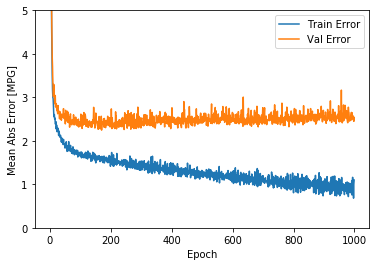

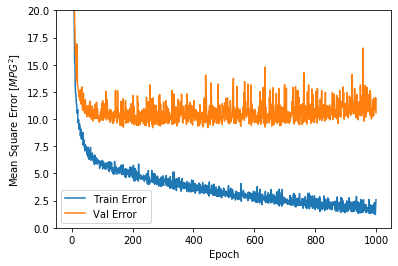

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este grafo mostra as pequenas melhoras, ou mesmo a diminuição do validation error após 100 epochs. Vamos atualizar o model.fit para que pare automaticamente o treinamento quando o validation score não aumentar mais. Usaremos o EarlyStopping callback que testa a condição do treinamento a cada epoch. Se um grupo de epochs decorre sem mostrar melhoras, o treinamento irá parar automaticamente.


..........................................................

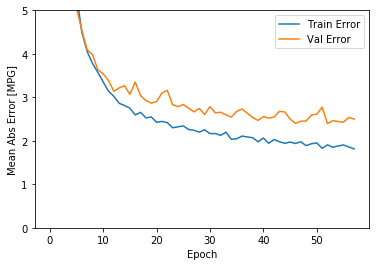

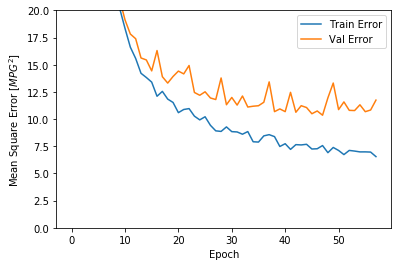

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

O gráfico mostra que no conjunto de validação, a média de erro é próximo de +/- 2MPG. Isso é bom? Deixaremos essa decisão a você.

Vamos ver quão bem o modelo generaliza usando o conjunto de teste, que não usamos para treinar o modelo. Isso diz quão bem podemos esperar que o modelo se saia quando usarmos na vida real.


In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.46 MPG


#Fazendo Predições
Finalmente, realizando previsão dos valores MPG usando o conjunto de teste.

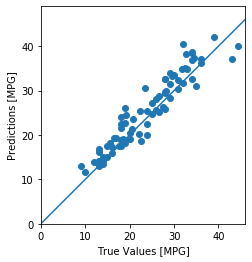

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que o nosso modelo prediz razoavelmente bem. Vamos dar uma olhada na distribuição dos erros.


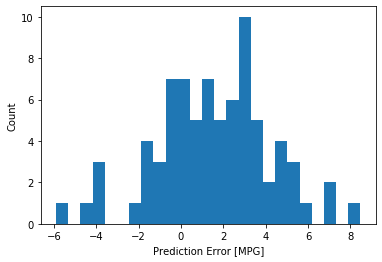

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Não é tão gaussiana, porém podemos esperar que por conta do número de exemplo é bem pequeno.


# Conclusão

Este notebook introduz algumas técnicas para trabalhar com problema de regressão.

Mean Sqaured Error(MSE), é uma função comum de loss usada para problemas de regressão.
Quando o dado de entrada de features tem diferentes intervalos, cada feature deve ser escalada para o mesmo intervalo.
Se não possui muitos dados de treinamento, uma técnica é preferir uma pequena rede com poucas camadas para evitar overfitting.
Early stopping é uma boa técnica para evitar overfitting.